#Import Libaries 

In [1]:
import os 
import re 
import time
import numpy as np 
import matplotlib.pyplot as plt 
import rasterio 
import pandas as pd 
from pathlib import Path 
import seaborn as sns 
from datetime import datetime
from tqdm import tqdm 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random
from torchvision.models import vgg19, VGG19_Weights
import torch.optim as optim
from math import exp
from torch.utils.data import DataLoader, random_split
import json
from torchvision.models import inception_v3
from torch.nn.utils import spectral_norm
from scipy import linalg
from torch.nn.modules.loss import _Loss
from torchvision.models.inception import Inception_V3_Weights  

Data Handling

In [2]:
class BigEarthNetSRDataset(Dataset):
    def __init__(self, root_dir, subset_size=None, augment=True, quick_init=True):
        self.root_dir = Path(root_dir) / 'BigEarthNet-S2' / 'BigEarthNet-S2'
        self.augment = augment
        self.quick_init = quick_init
        
        # Band groupings by resolution
        self.bands_20m = ['B05', 'B06', 'B07', 'B11', 'B12', 'B8A']
        self.bands_60m = ['B01', 'B09']
        self.bands_10m = ['B02', 'B03', 'B04', 'B08']
        
        # Normalization parameters
        self.norm_params = {
            '10m': {'mean': [341.58, 638.64, 477.62, 3610.56],
                   'std': [196.76, 262.62, 343.52, 958.73]},
            '20m': {'mean': [1042.65, 2849.99, 3454.13, 1951.60, 1070.14, 3691.64],
                   'std': [363.53, 662.72, 854.12, 484.09, 435.56, 884.44]},
            '60m': {'mean': [314.72, 3692.39],
                   'std': [127.19, 726.79]}
        }
        
        # Quick initialization - just list directories without validation
        print(f"Scanning directory: {self.root_dir}")
        self.patches = []
        
        for patch_dir in self.root_dir.iterdir():
            if patch_dir.is_dir():
                subdirs = [d for d in patch_dir.iterdir() if d.is_dir()]
                if subdirs:  # If there are any subdirectories
                    self.patches.append((subdirs[0], subdirs[0].name))
                    
                    if subset_size and len(self.patches) >= subset_size:
                        break
        
        print(f"\nFound {len(self.patches)} patches")

    def normalize_bands(self, bands, resolution):
        """Normalize bands using pre-computed statistics"""
        bands = np.array(bands)
        mean = np.array(self.norm_params[resolution]['mean'])
        std = np.array(self.norm_params[resolution]['std'])
        return (bands - mean[:, None, None]) / std[:, None, None]

    def apply_augmentation(self, bands_dict):
        """Apply data augmentation to all bands consistently"""
        if not self.augment:
            return bands_dict
            
        # Random horizontal flip
        if random.random() > 0.5:
            for key in bands_dict:
                bands_dict[key] = torch.flip(bands_dict[key], [-1])
                
        # Random vertical flip
        if random.random() > 0.5:
            for key in bands_dict:
                bands_dict[key] = torch.flip(bands_dict[key], [-2])
                
        return bands_dict

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        patch_dir, prefix = self.patches[idx]
        
        try:
            data = {}
            
            # Load and process each band group
            for band_group, band_list in [
                ('20m', self.bands_20m),
                ('60m', self.bands_60m),
                ('10m', self.bands_10m)
            ]:
                bands = []
                for band in band_list:
                    band_files = list(patch_dir.glob(f"*_{band}.tif"))
                    if not band_files:
                        print(f"Missing {band} in {patch_dir}")
                        return None
                        
                    with rasterio.open(band_files[0]) as src:
                        bands.append(src.read(1))
                
                # Stack and normalize
                bands = np.stack(bands)
                bands = self.normalize_bands(bands, band_group)
                data[f'bands_{band_group}'] = torch.from_numpy(bands).float()
            
            # Apply augmentation
            data = self.apply_augmentation(data)
            
            return data
            
        except Exception as e:
            print(f"Error loading patch {prefix}: {str(e)}")
            return None
            

Data split: 80% for training, Validation: 10%, Test: 10%

In [3]:
def create_data_splits(dataset, train_ratio=0.8, val_ratio=0.1, seed=42):
    """
    Split dataset into train, validation, and test sets
    """
    total_size = len(dataset)

    # Calculate minimum required samples
    min_samples_per_split = 2  # Minimum samples needed for each split
    min_total_required = min_samples_per_split * 3  # For train, val, test
    
    if total_size < min_total_required:
        raise ValueError(f"Dataset too small. Need at least {min_total_required} samples, but got {total_size}")
        
    # Calculate split sizes
    train_size = max(int(train_ratio * total_size), min_samples_per_split)
    val_size = max(int(val_ratio * total_size), min_samples_per_split)
    test_size = max(total_size - train_size - val_size, min_samples_per_split)
    
    # Adjust if necessary to ensure all splits have minimum size
    while (train_size + val_size + test_size) > total_size:
        if train_size > min_samples_per_split:
            train_size -= 1
        elif val_size > min_samples_per_split:
            val_size -= 1
        elif test_size > min_samples_per_split:
            test_size -= 1
    
    print(f"\nDataset splits:")
    print(f"- Total samples: {total_size}")
    print(f"- Train set: {train_size} samples")
    print(f"- Validation set: {val_size} samples")
    print(f"- Test set: {test_size} samples")
    
    # Create splits
    train_set, val_set, test_set = random_split(
        dataset, 
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(seed)
    )
    
    return train_set, val_set, test_set

def create_dataloaders(train_set, val_set, test_set, batch_size=8, num_workers=0):
    """
    Create DataLoader objects for each dataset split
    """
    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader

In [4]:
def collate_fn(batch):
    """Custom collate function to handle None values"""
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None
    
    return {
        key: torch.stack([item[key] for item in batch])
        for key in batch[0].keys()
    }

Model Architecture

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        return out

class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor=2):
        super(UpsampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * scale_factor * scale_factor, 
                            kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

class Generator(nn.Module):
    def __init__(self, n_res_blocks=16):
        super(Generator, self).__init__()
        
        # Initial feature extraction
        self.conv1_20m = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU()
        )
        
        self.conv1_60m = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU()
        )
        
        # Residual blocks with batch norm
        def make_res_block():
            return nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.PReLU(),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64)
            )
        
        self.res_blocks_20m = nn.ModuleList([make_res_block() for _ in range(n_res_blocks)])
        self.res_blocks_60m = nn.ModuleList([make_res_block() for _ in range(n_res_blocks)])

        # 20m path (60x60 -> 120x120): 2x upsampling
        self.upsample_20m = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU()
        )
        
        # 60m path (20x20 -> 120x120): 6x upsampling in steps
        # First step: 20x20 -> 40x40
        self.upsample_60m_1 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU()
        )
        # Second step: 40x40 -> 80x80
        self.upsample_60m_2 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU()
        )
        # Final step: 80x80 -> 120x120
        self.upsample_60m_3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.PReLU()
        )
        
        # Fusion and output
        self.fusion = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(64, 4, kernel_size=3, padding=1)
        )

    def forward(self, x_20m, x_60m):
        # Initial features
        feat_20m = self.conv1_20m(x_20m)
        feat_60m = self.conv1_60m(x_60m)
        
        # Residual blocks with skip connections
        res_20m = feat_20m
        res_60m = feat_60m
        
        for res_block_20m, res_block_60m in zip(self.res_blocks_20m, self.res_blocks_60m):
            res_20m = res_20m + 0.1 * res_block_20m(res_20m)
            res_60m = res_60m + 0.1 * res_block_60m(res_60m)
        
        # 20m upsampling path (60x60 -> 120x120)
        up_20m = self.upsample_20m(res_20m)  # 120x120
        
        # 60m upsampling path (20x20 -> 120x120)
        up_60m = self.upsample_60m_1(res_60m)  # 40x40
        up_60m = self.upsample_60m_2(up_60m)   # 80x80
        up_60m = F.interpolate(up_60m, size=(120, 120), mode='bilinear', align_corners=True)
        up_60m = self.upsample_60m_3(up_60m)   # Additional convolution after interpolation
        
        # Fusion
        feat = torch.cat([up_20m, up_60m], dim=1)
        out = self.fusion(feat)
        
        return torch.tanh(out)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        def discriminator_block(in_channels, out_channels, stride=1, normalize=True):
            layers = [
                spectral_norm(nn.Conv2d(in_channels, out_channels, 4, stride=stride, padding=1, bias=False))
            ]
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

            
        self.model = nn.Sequential(
            # No normalization for first layer
            *discriminator_block(4, 64, stride=2, normalize=False),  # 60x60
            *discriminator_block(64, 128, stride=2),                 # 30x30
            *discriminator_block(128, 256, stride=2),               # 15x15
            *discriminator_block(256, 512, stride=2),               # 8x8
            nn.Conv2d(512, 1, 4, padding=1)                        # 8x8
        )

    def forward(self, x):
        return self.model(x)

Training component 

In [6]:
class SRGANLoss(nn.Module):
    def __init__(self, device='cpu',lambda_content=0.01, lambda_perceptual=0.15, 
                 lambda_adv=0.001, label_smoothing=0.1):
        super(SRGANLoss, self).__init__()
        self.device = device
        self.lambda_content = lambda_content
        self.lambda_perceptual = lambda_perceptual
        self.lambda_adv = lambda_adv
        self.label_smoothing = label_smoothing
        # Initialize tracking variables with default values
        self.loss_history = []        # Initialize as empty list
        self.history_size = 10        # Default history size
        self.adaptive_weight = 1.0    # Default adaptive weight
        self.eps = 1e-8


        # VGG for perceptual loss
        self.vgg = vgg19(weights=VGG19_Weights.DEFAULT).features[:36].eval().to(device)
        for param in self.vgg.parameters():
            param.requires_grad = False
        
        self.mse = nn.MSELoss()

    def _normalize_predictions(self, pred):
        """Helper to normalize predictions to [0,1] range"""
        # First center around 0 with sigmoid
        pred = torch.sigmoid(pred)
        # Then add small noise and clamp
        noise = 0.02 * torch.randn_like(pred)
        return torch.clamp(pred + noise, 0, 1)

    def perceptual_loss(self, sr, hr):
        """Modified perceptual loss for 4-channel data"""
        # Convert 4 channels to 3 channels (using first 3 bands)
        sr_rgb = sr[:, :3, :, :]  # Take first 3 channels
        hr_rgb = hr[:, :3, :, :]  # Take first 3 channels
        
        # Normalize to VGG input range
        sr_rgb = (sr_rgb + 1) * 0.5  # Convert from [-1,1] to [0,1]
        hr_rgb = (hr_rgb + 1) * 0.5
        
        # Extract VGG features
        sr_features = self.vgg(sr_rgb)
        hr_features = self.vgg(hr_rgb)
        
        return self.mse(sr_features, hr_features)
    
    def update_adaptive_weight(self, g_loss, d_loss):
        """Update adaptive weight based on loss history"""
        self.loss_history.append((g_loss, d_loss))
        if len(self.loss_history) > self.history_size:
            self.loss_history.pop(0)
            
        if len(self.loss_history) >= 3:
            g_trend = sum(x[0] for x in self.loss_history[-3:]) / 3
            d_trend = sum(x[1] for x in self.loss_history[-3:]) / 3
            
            # Adjust weight to balance generator and discriminator
            if g_trend > d_trend * 2:
                self.adaptive_weight *= 0.95
            elif g_trend * 2 < d_trend:
                self.adaptive_weight *= 1.05
                
            self.adaptive_weight = max(0.1, min(10.0, self.adaptive_weight))

    def spectral_angle_mapper(self, sr, hr):
        """Spectral Angle Mapper (SAM) loss"""
        # Reshape to [B, C, H*W]
        sr_flat = sr.view(sr.size(0), sr.size(1), -1)
        hr_flat = hr.view(hr.size(0), hr.size(1), -1)
        
        # Calculate dot product across channels
        dot_product = torch.sum(sr_flat * hr_flat, dim=1)
        
        # Calculate magnitudes
        sr_mag = torch.sqrt(torch.sum(sr_flat**2, dim=1) + self.eps)
        hr_mag = torch.sqrt(torch.sum(hr_flat**2, dim=1) + self.eps)
        
        # Calculate SAM
        cos_angle = dot_product / (sr_mag * hr_mag)
        angle = torch.acos(torch.clamp(cos_angle, -1 + self.eps, 1 - self.eps))
        
        return angle.mean()
    
    def generator_loss(self, sr, hr, d_sr):
        # Content loss with stability clamp
        content_loss = F.l1_loss(sr, hr)
        content_loss = torch.clamp(content_loss, min=0.8, max=1.1) 

        # Normalized adversarial loss
        d_sr_norm = self._normalize_predictions(d_sr)
        real_labels = torch.ones_like(d_sr_norm).to(d_sr.device) * 0.9  
        adv_loss = F.binary_cross_entropy(d_sr_norm, real_labels)
        adv_loss = torch.clamp(adv_loss, max=1.0)

        # Normalize perceptual loss
        percep_loss = self.perceptual_loss(sr, hr)
        percep_loss = torch.clamp(percep_loss, min=0.2, max =0.6)
        
        # Combined loss with better scaling
        total_loss = (self.lambda_content * content_loss + 
                    self.lambda_perceptual * percep_loss + 
                    self.lambda_adv * adv_loss)


        return total_loss, {
            'content': content_loss.item(),
            'adv': adv_loss.item(),
            'perceptual': percep_loss.item(),
            'total': total_loss.item()
        }
    
    def discriminator_loss(self, real_pred, fake_pred):
        # Normalize predictions
        real_pred = self._normalize_predictions(real_pred)
        fake_pred = self._normalize_predictions(fake_pred)
        # Asymmetric label smoothing
        real_labels = torch.ones_like(real_pred).to(real_pred.device) * 0.9
        fake_labels = torch.zeros_like(fake_pred).to(fake_pred.device) * 0.1

       
        # Hinge-like BCE loss
        margin = 0.2
        real_loss = F.binary_cross_entropy(
            real_pred,
            torch.clamp(real_labels - margin, 0, 1)
        )
        fake_loss = F.binary_cross_entropy(
            fake_pred,
            torch.clamp(fake_labels + margin, 0, 1)
        )
        
        return 0.5 * (real_loss + fake_loss)

In [7]:
class TrainingConfig:
    def __init__(self):
        # Training parameters
        self.num_epochs = 100
        self.batch_size = 8
        self.lr_generator = 2e-4
        self.lr_discriminator = 2e-4
        self.beta1 = 0.5
        self.beta2 = 0.999
        
        # Loss weights
        self.lambda_content = 0.01  # Weight for content loss
        self.lambda_perceptual = 0.15
        self.lambda_adv = 0.001
        # Added stability parameters
        self.gp_lambda = 10.0         # Gradient penalty weight
        self.d_updates = 1         # Discriminator updates per generator update

        # Stability parameters
        self.clip_value = 0.005
        self.n_critic = 5
        
        # Learning rate schedule
        self.warmup_epochs = 10
        self.lr_decay_epochs = 10
        self.lr_decay_factor = 0.5
        
        # Logging and saving
        self.save_interval = 1
        self.log_interval = 10
        self.save_dir = "checkpoints"
        self.log_dir = "logs"
        
        self.label_smoothing = 0.1
        
        os.makedirs(self.save_dir, exist_ok=True)
        os.makedirs(self.log_dir, exist_ok=True)


In [8]:
class TrainingLogger:
    def __init__(self, log_dir):
        self.log_dir = log_dir
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.log_file = os.path.join(log_dir, f"training_log_{self.timestamp}.json")
        self.history = {
            'train_losses': [],
            'val_metrics': [],
            'epoch_times': [],
            'best_epoch': 0,
            'best_metrics': None
        }
    
    def log_epoch(self, epoch, train_losses, val_metrics, epoch_time):
        epoch_data = {
            'epoch': epoch,
            'train_losses': train_losses,
            'val_metrics': val_metrics,
            'epoch_time': epoch_time
        }
        self.history['train_losses'].append(train_losses)
        self.history['val_metrics'].append(val_metrics)
        self.history['epoch_times'].append(epoch_time)
        
        # Update best metrics
        if self.history['best_metrics'] is None or \
           val_metrics['PSNR'] > self.history['best_metrics']['PSNR']:
            self.history['best_metrics'] = val_metrics
            self.history['best_epoch'] = epoch
        
        # Save to file
        with open(self.log_file, 'w') as f:
            json.dump(self.history, f, indent=4)
        
        return epoch_data

In [9]:
class SRGANTrainer:
    def __init__(self, generator, discriminator, metrics, config):
        self.config = config
        self.device = torch.device('cpu')
        print(f"Initializing trainer on device: {self.device}")
        # Add stability monitor
        self.stability_monitor = StabilityMonitor()
        # Models
        self.generator = generator.to(self.device)
        self.discriminator = discriminator.to(self.device)
        
        # Initialize criterion with all parameters
        self.criterion = SRGANLoss(
            device=self.device,
            lambda_content=config.lambda_content,
            lambda_perceptual=config.lambda_perceptual,
            lambda_adv=config.lambda_adv,
            label_smoothing=config.label_smoothing  # Add from config
        )
        
        # Optimizers
        self.g_optimizer = torch.optim.Adam(
            self.generator.parameters(),
            lr=config.lr_generator,
            betas=(config.beta1, config.beta2)
        )
        self.d_optimizer = torch.optim.Adam(
            self.discriminator.parameters(),
            lr=config.lr_discriminator,
            betas=(config.beta1, config.beta2)
        )
        
        # Schedulers
        self.g_scheduler = torch.optim.lr_scheduler.StepLR(
            self.g_optimizer,
            step_size=config.lr_decay_epochs,
            gamma=config.lr_decay_factor
        )
        self.d_scheduler = torch.optim.lr_scheduler.StepLR(
            self.d_optimizer,
            step_size=config.lr_decay_epochs,
            gamma=config.lr_decay_factor
        )
        
        # Metrics and logging
        self.metrics = metrics
        self.logger = TrainingLogger(config.log_dir)

    def _adjust_learning_rate(self, epoch):
        """Single learning rate adjustment method"""
        if epoch < self.config.warmup_epochs:
            factor = (epoch + 1) / self.config.warmup_epochs
        else:
            factor = self.config.lr_decay_factor ** (epoch // self.config.lr_decay_epochs)
            
        for param_group in self.g_optimizer.param_groups:
            param_group['lr'] = self.config.lr_generator * factor
        for param_group in self.d_optimizer.param_groups:
            param_group['lr'] = self.config.lr_discriminator * factor

    def train_full(self, train_loader, val_loader, run_name="SRGAN_training"):
        """Full training implementation with monitoring"""
        print(f"Starting full training on {self.device}")
        print(f"Training set size: {len(train_loader.dataset)}")
        print(f"Validation set size: {len(val_loader.dataset)}")
        
        # Initialize tracking
        training_history = {
            'generator_losses': [],
            'discriminator_losses': [],
            'component_losses': {'content': [], 'perceptual': [], 'adv': []},
            'discriminator_scores': {'real': [], 'fake': []},
            'validation_metrics': {'PSNR': [], 'SSIM': [], 'MSE': [], 'FID': []},
            'learning_rates': {'generator': [], 'discriminator': []}
        }
        
        # Setup output directories
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        output_dir = Path(f"training_outputs/{run_name}_{timestamp}")
        output_dir.mkdir(parents=True, exist_ok=True)
        sample_dir = output_dir / "samples"
        sample_dir.mkdir(exist_ok=True)
        
        best_psnr = 0
        start_time = time.time()
        
        for epoch in range(self.config.num_epochs):
            # Training phase
            epoch_metrics = self._train_epoch(train_loader, epoch)
            
            # Validation phase
            val_metrics = self._validate(val_loader)
            
            # Update history
            self._update_history(training_history, epoch_metrics, val_metrics)
            
            # Step schedulers
            self.g_scheduler.step()
            self.d_scheduler.step()

            # Save checkpoints and samples
            if val_metrics['PSNR'] > best_psnr:
                best_psnr = val_metrics['PSNR']
                self._save_checkpoint(epoch, val_metrics, output_dir / "best_model.pth")
            
            if epoch % self.config.save_interval == 0:
                self._generate_samples(val_loader, sample_dir / f"epoch_{epoch}.png")
                self._plot_training_curves(training_history, output_dir / "training_curves.png")
            
            # Print progress

            self._print_epoch_summary(epoch, epoch_metrics, val_metrics, time.time() - start_time)
            
            # Save history
            with open(output_dir / "training_history.json", 'w') as f:
                json.dump(training_history, f, indent=4)
        
        return training_history

    def _train_epoch(self, train_loader, epoch):
        """Train for one epoch"""
        self.generator.train()
        self.discriminator.train()
        
        epoch_metrics = {
            'generator_losses': [],
            'discriminator_losses': [],
            'component_losses': {'content': [], 'perceptual': [], 'adv': []},
            'discriminator_scores': {'real': [], 'fake': []}
        }
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{self.config.num_epochs}')
        for batch in pbar:
            if batch is None:
                continue
            
            # Get data
            x_20m = batch['bands_20m'].to(self.device)
            x_60m = batch['bands_60m'].to(self.device)
            real_hr = batch['bands_10m'].to(self.device)
            
            # Train discriminator
            fake_hr = self.generator(x_20m, x_60m)
            d_loss = self._train_discriminator(real_hr, fake_hr)
            
            # Train generator
            g_loss, components = self._train_generator(real_hr, fake_hr)
            
            # Update metrics
            self._update_batch_metrics(epoch_metrics, g_loss, d_loss, components)
            
            # Update progress bar
            pbar.set_postfix({
                'G_loss': f"{g_loss.item():.4f}",
                'D_loss': f"{d_loss.item():.4f}"
            })
        
        # Calculate epoch averages
        return {k: np.mean(v) if isinstance(v, list) else 
               {k2: np.mean(v2) for k2, v2 in v.items()}
               for k, v in epoch_metrics.items()}

    def _update_batch_metrics(self, metrics, g_loss, d_loss, components):
        """Update metrics with batch results"""
        metrics['generator_losses'].append(g_loss.item())
        metrics['discriminator_losses'].append(d_loss.item())
        
        for key, value in components.items():
            metrics['component_losses'][key].append(value)

    def _generate_samples(self, val_loader, save_path):
        """Generate and save sample outputs"""
        self.generator.eval()
        with torch.no_grad():
            batch = next(iter(val_loader))
            if batch is not None:
                x_20m = batch['bands_20m'].to(self.device)
                x_60m = batch['bands_60m'].to(self.device)
                real_hr = batch['bands_10m'].to(self.device)
                
                fake_hr = self.generator(x_20m, x_60m)
                
                # Plot results
                plt.figure(figsize=(15, 5))
                
                plt.subplot(1, 3, 1)
                plt.imshow(x_20m[0, :3].cpu().permute(1, 2, 0))
                plt.title('Input (20m bands)')
                
                plt.subplot(1, 3, 2)
                plt.imshow(fake_hr[0, :3].cpu().permute(1, 2, 0))
                plt.title('Generated HR')
                
                plt.subplot(1, 3, 3)
                plt.imshow(real_hr[0, :3].cpu().permute(1, 2, 0))
                plt.title('Real HR')
                
                plt.savefig(save_path)
                plt.close()

    def _print_epoch_summary(self, epoch, train_metrics, val_metrics, elapsed_time):
        """Print epoch training summary"""
        print(f"\nEpoch {epoch+1}/{self.config.num_epochs}")
        print(f"Time elapsed: {elapsed_time:.2f}s")
        print("\nTraining Metrics:")
        print(f"Generator Loss: {train_metrics['generator_losses']:.4f}")
        print(f"Discriminator Loss: {train_metrics['discriminator_losses']:.4f}")
        print("\nValidation Metrics:")
        for key, value in val_metrics.items():
            print(f"{key}: {value:.4f}")

    def _plot_training_curves(self, history, save_path):
        """Plot and save training curves"""
        plt.figure(figsize=(20, 15))
        
        # Plot losses
        plt.subplot(3, 2, 1)
        plt.plot(history['generator_losses'], label='Generator')
        plt.plot(history['discriminator_losses'], label='Discriminator')
        plt.title('Losses')
        plt.legend()
        
        # Plot component losses
        plt.subplot(3, 2, 2)
        for key in history['component_losses']:
            plt.plot(history['component_losses'][key], label=key)
        plt.title('Component Losses')
        plt.legend()
        
        # Plot discriminator scores
        plt.subplot(3, 2, 3)
        plt.plot(history['discriminator_scores']['real'], label='Real')
        plt.plot(history['discriminator_scores']['fake'], label='Fake')
        plt.title('Discriminator Scores')
        plt.legend()
        
        # Plot validation metrics
        plt.subplot(3, 2, 4)
        for key in ['PSNR', 'SSIM']:
            plt.plot(history['validation_metrics'][key], label=key)
        plt.title('Validation Metrics')
        plt.legend()
        
        # Plot learning rates
        plt.subplot(3, 2, 5)
        plt.plot(history['learning_rates']['generator'], label='Generator')
        plt.plot(history['learning_rates']['discriminator'], label='Discriminator')
        plt.title('Learning Rates')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()


            
    def _validate(self, val_loader):
        val_metrics = []
        
        with torch.no_grad():
            for batch in val_loader:
                if batch is None:
                    continue
                    
                x_20m = batch['bands_20m'].to(self.device)
                x_60m = batch['bands_60m'].to(self.device)
                real_hr = batch['bands_10m'].to(self.device)
                
                fake_hr = self.generator(x_20m, x_60m)
                batch_metrics = self.metrics.evaluate_batch(fake_hr, real_hr)
                val_metrics.append(batch_metrics)
        
        # Average metrics
        avg_metrics = {}
        for metric in val_metrics[0].keys():
            avg_metrics[metric] = np.mean([m[metric] for m in val_metrics])
        
        return avg_metrics
    
    def gradient_penalty(self, real_samples, fake_samples):
        """Calculate gradient penalty for WGAN-GP"""
        alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(self.device)
        interpolates = alpha * real_samples + (1 - alpha) * fake_samples
        interpolates.requires_grad_(True)
        
        d_interpolates = self.discriminator(interpolates)
        gradients = torch.autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones_like(d_interpolates),
            create_graph=True,
            retain_graph=True
        )[0]
        
        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty
    
    def _train_generator(self, real_hr, fake_hr):
        """Train generator with improved stability"""
        self.g_optimizer.zero_grad()

        # Get discriminator predictions on generated images
        fake_pred = self.discriminator(fake_hr)
        
        # Calculate generator loss components
        g_loss, components = self.criterion.generator_loss(fake_hr, real_hr, fake_pred)
        
        g_loss.backward()
        
        # Add gradient clipping
        torch.nn.utils.clip_grad_norm_(
            self.generator.parameters(), 
            self.config.clip_value
        )
        
        self.g_optimizer.step()
        return g_loss, components

    def _train_discriminator(self, real_hr, fake_hr):
        """Train discriminator with improved stability"""
        self.d_optimizer.zero_grad()

        # Add noise to inputs for regularization
        noise_factor = 0.02
        real_noisy = real_hr + noise_factor * torch.randn_like(real_hr)
        fake_noisy = fake_hr + noise_factor * torch.randn_like(fake_hr)
        
        # Get predictions
        real_pred = self.discriminator(real_noisy)
        fake_pred = self.discriminator(fake_noisy.detach())  # detach to avoid training generator

        # Calculate discriminator loss
        d_loss = self.criterion.discriminator_loss(real_pred, fake_pred)
        d_loss.backward()

        # Add gradient clipping
        torch.nn.utils.clip_grad_norm_(
            self.discriminator.parameters(), 
            self.config.clip_value*0.5
        )

        self.d_optimizer.step()
        return d_loss

    def _update_history(self, training_history, epoch_metrics, val_metrics):
        """Update training history with latest metrics"""
        # Update training metrics
        training_history['generator_losses'].append(epoch_metrics['generator_losses'])
        training_history['discriminator_losses'].append(epoch_metrics['discriminator_losses'])

        # Update component losses
        for key in epoch_metrics['component_losses']:
            training_history['component_losses'][key].append(
                epoch_metrics['component_losses'][key]
            )

        # Update validation metrics
        for key in val_metrics:
            training_history['validation_metrics'][key].append(val_metrics[key])

        # Update learning rates
        training_history['learning_rates']['generator'].append(
            self.g_optimizer.param_groups[0]['lr']
        )
        training_history['learning_rates']['discriminator'].append(
            self.d_optimizer.param_groups[0]['lr']
        )

    def _adjust_hyperparameters(self, stability_checks):
        """Adjust training parameters based on stability checks"""
        if not stability_checks['g_loss_decreasing']:
            # Reduce generator learning rate
            for param_group in self.g_optimizer.param_groups:
                param_group['lr'] *= 0.5

        if not stability_checks['d_loss_stable']:
            # Reduce discriminator learning rate
            for param_group in self.d_optimizer.param_groups:
                param_group['lr'] *= 0.5

        if not stability_checks['discrimination_ok']:
            # Adjust adversarial weight
            self.criterion.lambda_adv *= 0.5

    def _save_checkpoint(self, epoch, metrics, save_path):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'generator_state_dict': self.generator.state_dict(),
            'discriminator_state_dict': self.discriminator.state_dict(),
            'g_optimizer_state_dict': self.g_optimizer.state_dict(),
            'd_optimizer_state_dict': self.d_optimizer.state_dict(),
            'g_scheduler_state_dict': self.g_scheduler.state_dict(),
            'd_scheduler_state_dict': self.d_scheduler.state_dict(),
            'metrics': metrics
        }

        torch.save(checkpoint, save_path)
    

In [10]:
class StabilityMonitor:
    def __init__(self):
        self.metrics_history = {
            'g_loss': [],
            'd_loss': [],
            'real_pred_mean': [],
            'fake_pred_mean': [],
            'content_loss': [],
            'adv_loss': [],
            'percep_loss': []
        }
        
    def update(self, metrics):
        for key, value in metrics.items():
            self.metrics_history[key].append(value)
    
    def check_stability(self):
        recent = lambda x: x[-10:]  # Look at last 10 iterations
        
        checks = {
            'g_loss_decreasing': np.mean(np.diff(recent(self.metrics_history['g_loss']))) < 0,
            'd_loss_stable': np.std(recent(self.metrics_history['d_loss'])) < 0.5,
            'discrimination_ok': (np.mean(recent(self.metrics_history['real_pred_mean'])) > 
                                np.mean(recent(self.metrics_history['fake_pred_mean'])))
        }
        
        return all(checks.values()), checks

Evaluation 

In [11]:
class EvaluationMetrics:
    def __init__(self, device=None):
        if device is None:
            self.device = torch.device('cpu')
        else:
            self.device = device
            
        print(f"Initializing metrics on device: {self.device}")
        
        # Initialize inception model for FID
        weights = Inception_V3_Weights.DEFAULT
        self.inception = inception_v3(weights=weights)
        self.inception = self.inception.to(self.device)
        self.inception.eval()
        # Remove last linear layer
        self.inception.fc = nn.Identity()
        
        # Initialize criterion
        self.criterion = SRGANLoss(self.device)

    def gaussian(self, window_size, sigma):
        """Generate 1D Gaussian kernel"""
        gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) 
                            for x in range(window_size)])
        return gauss/gauss.sum()

    def create_window(self, window_size, channel):
        """Create SSIM window"""
        _1D_window = self.gaussian(window_size, 1.5).unsqueeze(1)
        _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
        window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
        return window

    def calculate_psnr(self, sr, hr):
        """Peak Signal-to-Noise Ratio"""
        mse = torch.mean((sr - hr) ** 2)
        return 20 * torch.log10(1.0 / torch.sqrt(mse))

    def calculate_mse(self, sr, hr):
        """Mean Squared Error"""
        return F.mse_loss(sr, hr)

    def calculate_ssim(self, sr, hr, window_size=11):
        """Structural Similarity Index"""
        channel = sr.size(1)
        window = self.create_window(window_size, channel).to(self.device)
        
        mu1 = F.conv2d(sr, window, padding=window_size//2, groups=channel)
        mu2 = F.conv2d(hr, window, padding=window_size//2, groups=channel)
        
        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1 * mu2
        
        sigma1_sq = F.conv2d(sr * sr, window, padding=window_size//2, groups=channel) - mu1_sq
        sigma2_sq = F.conv2d(hr * hr, window, padding=window_size//2, groups=channel) - mu2_sq
        sigma12 = F.conv2d(sr * hr, window, padding=window_size//2, groups=channel) - mu1_mu2
        
        C1 = 0.01 ** 2
        C2 = 0.03 ** 2
        
        ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / \
                   ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
        
        return ssim_map.mean()

    def calculate_activation_statistics(self, images):
        """Calculate mean and covariance of inception features"""
        # Adapt images for inception (RGB, normalized)
        if images.size(1) == 4:  # If 4 channels, take first 3
            images = images[:, :3]
        images = (images + 1) / 2  # Convert from [-1, 1] to [0, 1]
        
        # Get inception features
        features = self.inception(images).cpu().numpy()
        mu = np.mean(features, axis=0)
        sigma = np.cov(features, rowvar=False)
        return mu, sigma

    def calculate_fid(self, sr, hr, batch_size=32):
        """Fréchet Inception Distance"""
        # Calculate activation statistics for both real and generated images
        mu1, sigma1 = self.calculate_activation_statistics(sr)
        mu2, sigma2 = self.calculate_activation_statistics(hr)
        
        # Calculate FID
        ssdiff = np.sum((mu1 - mu2) ** 2.0)
        covmean = linalg.sqrtm(sigma1.dot(sigma2))
        
        if np.iscomplexobj(covmean):
            covmean = covmean.real
            
        fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        return float(fid)

    def evaluate_batch(self, sr, hr):
        """Evaluate all metrics for a batch"""
        with torch.no_grad():
            metrics = {
                'PSNR': self.calculate_psnr(sr, hr).item(),
                'MSE': self.calculate_mse(sr, hr).item(),
                'SSIM': self.calculate_ssim(sr, hr).item(),
                'FID': self.calculate_fid(sr, hr)
            }
        return metrics

Test Functions

In [12]:
def test_dataset():
    # Create dataset and dataloader
    dataset = BigEarthNetSRDataset(".")
    try:
        # Create splits
        train_set, val_set, test_set = create_data_splits(dataset)
        
        # Test loading a batch
        if len(train_set) > 0:
            train_loader = DataLoader(
                train_set, 
                batch_size=min(4, len(train_set)),  # Ensure batch size doesn't exceed dataset size
                shuffle=True,
                collate_fn=collate_fn,
                num_workers=0
            )
            
            print("\nTesting batch loading...")
            for batch in train_loader:
                if batch is not None:
                    print("\nBatch shapes:")
                    for key, value in batch.items():
                        print(f"{key}: {value.shape}")
                    break
                    
    except ValueError as e:
        print(f"Error: {str(e)}")
        
#if __name__ == "__main__":
#    test_dataset()

In [13]:
def test_models():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create models
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    
    # Test with dummy data
    batch_size = 2
    x_20m = torch.randn(batch_size, 6, 60, 60).to(device)    # 20m bands
    x_60m = torch.randn(batch_size, 2, 20, 20).to(device)    # 60m bands
    
    # Test generator
    with torch.no_grad():
        print("\nInput shapes:")
        print(f"20m bands: {x_20m.shape}")
        print(f"60m bands: {x_60m.shape}")
        
        sr_output = generator(x_20m, x_60m)
        print(f"Generator output shape: {sr_output.shape}")
        
        # Test discriminator
        d_output = discriminator(sr_output)
        print(f"Discriminator output shape: {d_output.shape}")

if __name__ == "__main__":
    test_models()

Using device: cpu

Input shapes:
20m bands: torch.Size([2, 6, 60, 60])
60m bands: torch.Size([2, 2, 20, 20])
Generator output shape: torch.Size([2, 4, 120, 120])
Discriminator output shape: torch.Size([2, 1, 6, 6])


Starting verification process...
Verifying loss computation...

Generator Loss Components:
content: 1.1000
adv: 0.6444
perceptual: 0.2000
total: 0.0416

Discriminator Loss: 0.6773

Loss computation working: True

Verifying generator output...
Input shapes:
20m bands: torch.Size([2, 6, 60, 60])
60m bands: torch.Size([2, 2, 20, 20])
Output shape: torch.Size([2, 4, 120, 120])
Output range: [-0.98, 0.94]

Generator output correct: True

Verifying training stability...
Scanning directory: BigEarthNet-S2\BigEarthNet-S2

Found 115 patches

Dataset splits:
- Total samples: 115
- Train set: 92 samples
- Validation set: 11 samples
- Test set: 12 samples

Dataset splits:
- Train set: 92 samples
- Validation set: 11 samples
- Test set: 12 samples
Running training iterations...
Iteration 1/5 completed
Iteration 2/5 completed
Iteration 3/5 completed
Iteration 4/5 completed
Iteration 5/5 completed

Stability Metrics:
g_loss_std: 0.0244
d_loss_std: 0.0555
real_fake_diff: 0.3286
g_loss_trend: -0.0000
d

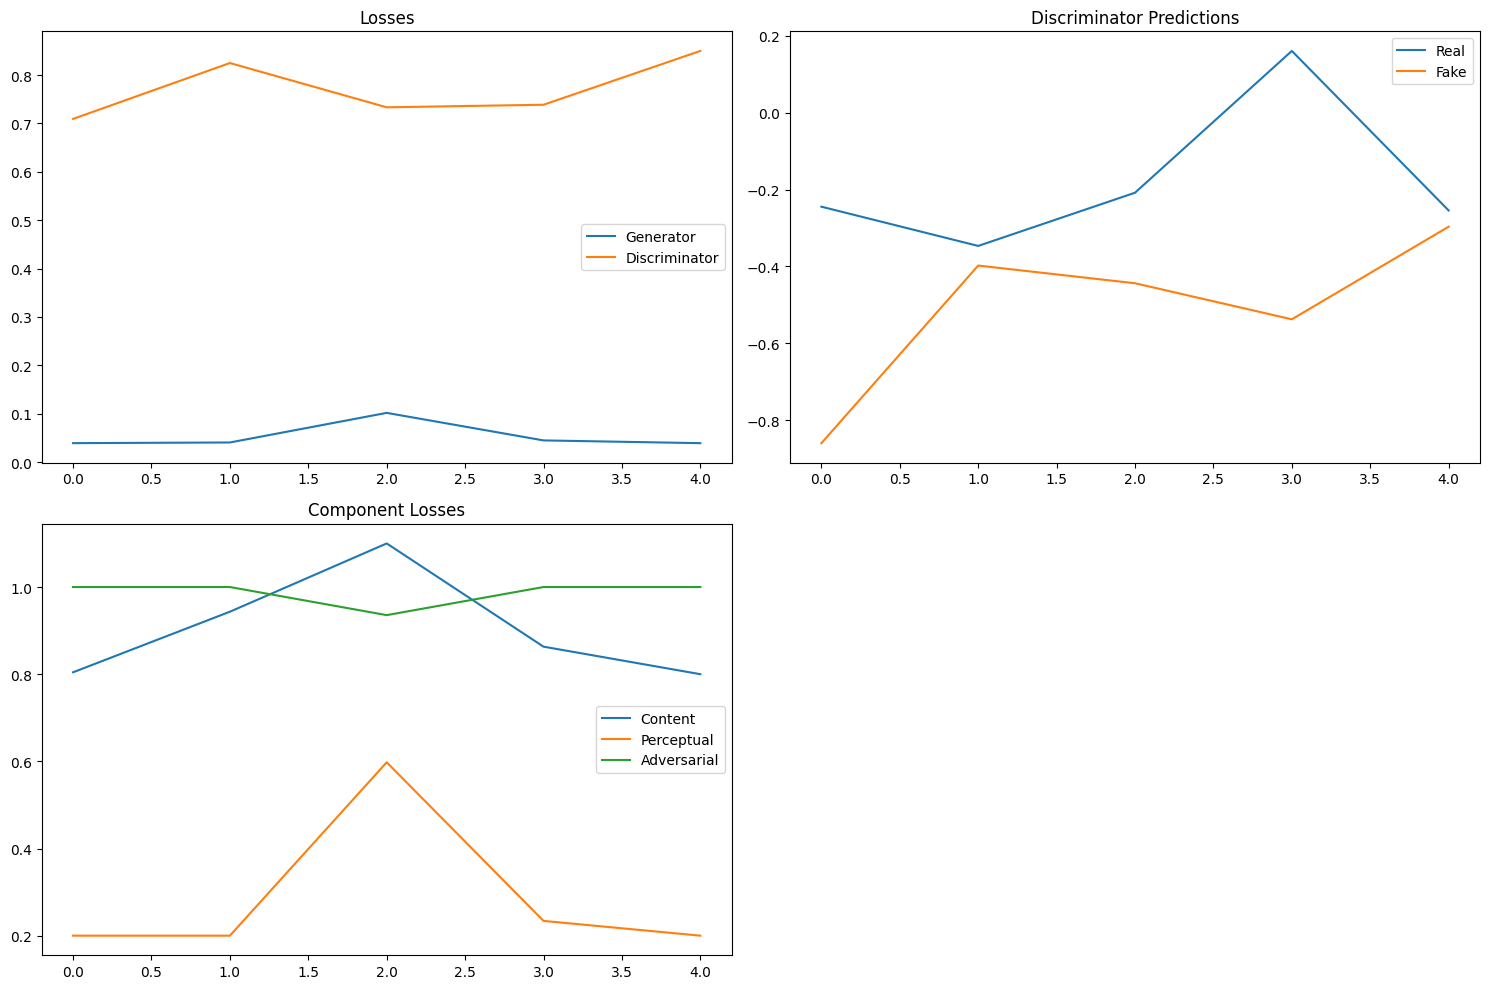


Training step working: True


In [14]:
class TrainingVerification:
    @staticmethod
    def verify_loss_computation():
        print("Verifying loss computation...")
        device = torch.device('cpu')
        
        # Create dummy data
        sr = torch.randn(2, 4, 120, 120).to(device)
        hr = torch.randn(2, 4, 120, 120).to(device)
        d_sr = torch.rand(2, 1).to(device)
        d_hr = torch.rand(2, 1).to(device)
        
        # Initialize loss with new parameters
        config = TrainingConfig()
        config.batch_size = min(2, len(train_set))  # Ensure batch size doesn't exceed dataset size
        
        train_loader = DataLoader(
            train_set,
            batch_size=config.batch_size,
            shuffle=True,
            collate_fn=collate_fn
        )
        
        # Test generator loss
        g_loss, components = criterion.generator_loss(sr, hr, d_sr)
        print("\nGenerator Loss Components:")
        for key, value in components.items():
            print(f"{key}: {value:.4f}")
            
        # Test discriminator loss
        d_loss = criterion.discriminator_loss(d_hr, d_sr)
        print(f"\nDiscriminator Loss: {d_loss.item():.4f}")
        
        return g_loss is not None and d_loss is not None
    
    @staticmethod
    def verify_generator_output():
        print("\nVerifying generator output...")
        device = torch.device('cpu')
        
        # Create model
        generator = Generator().to(device)
        
        # Test data
        x_20m = torch.randn(2, 6, 60, 60).to(device)
        x_60m = torch.randn(2, 2, 20, 20).to(device)
        
        # Forward pass
        print("Input shapes:")
        print(f"20m bands: {x_20m.shape}")
        print(f"60m bands: {x_60m.shape}")
        
        with torch.no_grad():
            output = generator(x_20m, x_60m)
            print(f"Output shape: {output.shape}")
            print(f"Output range: [{output.min():.2f}, {output.max():.2f}]")
            
        return output.shape == torch.Size([2, 4, 120, 120])

    @staticmethod
    def verify_training_stability():
        print("\nVerifying training stability...")
        device = torch.device('cpu')
        
        # Create small dataset
        dataset = BigEarthNetSRDataset(".")
        # For very small datasets, use simpler split
        total_size = len(dataset)
        if total_size < 6:
            print(f"Small dataset detected ({total_size} samples). Using simple split.")
            train_size = max(2, int(0.6 * total_size))
            val_size = max(1, int(0.2 * total_size))
            test_size = total_size - train_size - val_size
            
            splits = [train_size, val_size, test_size]
            train_set, val_set, test_set = random_split(
                dataset, 
                splits,
                generator=torch.Generator().manual_seed(42)
            )
        else:
            train_set, val_set, test_set = create_data_splits(dataset)
        
        print(f"\nDataset splits:")
        print(f"- Train set: {len(train_set)} samples")
        print(f"- Validation set: {len(val_set)} samples")
        print(f"- Test set: {len(test_set)} samples")
        
        # Create dataloader
        config = TrainingConfig()
        config.batch_size = min(2, len(train_set))  # Ensure batch size doesn't exceed dataset size
        
        train_loader = DataLoader(
            train_set,
            batch_size=config.batch_size,
            shuffle=True,
            collate_fn=collate_fn
        )
        
        # Initialize models
        generator = Generator().to(device)
        discriminator = Discriminator().to(device)
        
        # Initialize loss with correct parameter names
        criterion = SRGANLoss(
            device=device,
            lambda_content=config.lambda_content,      
            lambda_perceptual=config.lambda_perceptual,   
            lambda_adv=config.lambda_adv,         
            label_smoothing=config.label_smoothing
        )
        
        g_optimizer = torch.optim.Adam(
            generator.parameters(),
            lr=config.lr_generator,
            betas=(config.beta1, config.beta2)
        )
        
        d_optimizer = torch.optim.Adam(
            discriminator.parameters(),
            lr=config.lr_discriminator,
            betas=(config.beta1, config.beta2)
        )
        
        # Tracking metrics
        metrics = {
            'g_losses': [],
            'd_losses': [],
            'd_real': [],
            'd_fake': [],
            'content_losses': [],
            'perceptual_losses': [],
            'adv_losses': []
        }
        
        print("Running training iterations...")
        for batch_idx, batch in enumerate(train_loader):
            if batch is None or batch_idx >= 5:
                continue
                
            x_20m = batch['bands_20m'].to(device)
            x_60m = batch['bands_60m'].to(device)
            real_hr = batch['bands_10m'].to(device)
            
            # Train discriminator
            d_optimizer.zero_grad()
            fake_hr = generator(x_20m, x_60m)
            
            real_pred = discriminator(real_hr)
            fake_pred = discriminator(fake_hr.detach())
            
            d_loss = criterion.discriminator_loss(real_pred, fake_pred)
            d_loss.backward()
            d_optimizer.step()
            
            # Train generator
            g_optimizer.zero_grad()
            fake_pred = discriminator(fake_hr)
            g_loss, loss_components = criterion.generator_loss(fake_hr, real_hr, fake_pred)
            g_loss.backward()
            g_optimizer.step()
            
            # Record metrics
            metrics['g_losses'].append(g_loss.item())
            metrics['d_losses'].append(d_loss.item())
            metrics['d_real'].append(real_pred.mean().item())
            metrics['d_fake'].append(fake_pred.mean().item())
            metrics['content_losses'].append(loss_components['content'])
            metrics['perceptual_losses'].append(loss_components['perceptual'])
            metrics['adv_losses'].append(loss_components['adv'])
            
            print(f"Iteration {batch_idx + 1}/5 completed")
        
        # Analyze stability
        stability_metrics = {
            'g_loss_std': np.std(metrics['g_losses']),
            'd_loss_std': np.std(metrics['d_losses']),
            'real_fake_diff': np.mean(metrics['d_real']) - np.mean(metrics['d_fake']),
            'g_loss_trend': metrics['g_losses'][-1] - metrics['g_losses'][0],
            'd_loss_trend': metrics['d_losses'][-1] - metrics['d_losses'][0]
        }
        
        print("\nStability Metrics:")
        for key, value in stability_metrics.items():
            print(f"{key}: {value:.4f}")
        
        plt.figure(figsize=(15, 10))
        
        # Plot losses
        plt.subplot(2, 2, 1)
        plt.plot(metrics['g_losses'], label='Generator')
        plt.plot(metrics['d_losses'], label='Discriminator')
        plt.title('Losses')
        plt.legend()
        
        # Plot discriminator outputs
        plt.subplot(2, 2, 2)
        plt.plot(metrics['d_real'], label='Real')
        plt.plot(metrics['d_fake'], label='Fake')
        plt.title('Discriminator Predictions')
        plt.legend()
        
        # Plot component losses
        plt.subplot(2, 2, 3)
        plt.plot(metrics['content_losses'], label='Content')
        plt.plot(metrics['perceptual_losses'], label='Perceptual')
        plt.plot(metrics['adv_losses'], label='Adversarial')
        plt.title('Component Losses')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        return (stability_metrics['g_loss_std'] < 100 and
                stability_metrics['d_loss_std'] < 10 and
                abs(stability_metrics['real_fake_diff']) > 0.1)

def run_verification():
    print("Starting verification process...")
    
    # Verify loss computation
    loss_ok = TrainingVerification.verify_loss_computation()
    print(f"\nLoss computation working: {loss_ok}")
    
    # Verify generator
    gen_ok = TrainingVerification.verify_generator_output()
    print(f"\nGenerator output correct: {gen_ok}")
    
    # Verify training step
    train_ok = TrainingVerification.verify_training_stability()
    print(f"\nTraining step working: {train_ok}")
    
    return loss_ok and gen_ok and train_ok
STABILITY_REQUIREMENTS = {
    'g_loss_trend': (-10, 0),    # Should decrease
    'g_loss_std': (0, 10),       # Not too volatile
    'd_loss_std': (0, 1),        # Stable discriminator
    'real_fake_diff': (0.2, 2.0)  # Good separation but not too extreme
}

def check_stability(metrics):
    for key, (min_val, max_val) in STABILITY_REQUIREMENTS.items():
        if not min_val <= metrics[key] <= max_val:
            print(f"Stability check failed for {key}: {metrics[key]}")
            return False
    return True
if __name__ == "__main__":
    run_verification()